# Analytical Data Source

## Step 10. Provide

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler
import time
import os
from tempfile import TemporaryDirectory

df = pd.read_csv('../data/ds_salaries_cleaned.csv')

## Step 11. Make available

In [2]:
print(df.shape)
df.head()

(3755, 9)


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior-level/Expert,Full-Time,Data Scientist,85847,ES,100,ES,L
1,2023,Mid-level/Intermediate,Contract,ML Engineer,30000,US,100,US,S
2,2023,Mid-level/Intermediate,Contract,ML Engineer,25500,US,100,US,S
3,2023,Senior-level/Expert,Full-Time,Data Scientist,175000,CA,100,CA,M
4,2023,Senior-level/Expert,Full-Time,Data Scientist,120000,CA,100,CA,M


In [3]:
df["job_title"].value_counts()

job_title
Data Engineer                1110
Data Scientist                935
Data Analyst                  744
Machine Learning Engineer     333
Analytics Engineer            118
Applied Scientist             113
Data Science Manager          111
Data Architect                105
Research Scientist             93
Research Engineer              59
ML Engineer                    34
Name: count, dtype: int64

## Step 12. Select

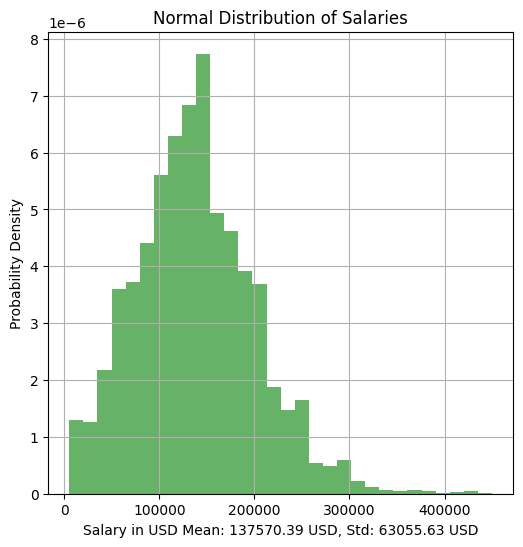

In [4]:
# draw a normalized histogram of the salary
import matplotlib.pyplot as plt
mean = df['salary_in_usd'].mean()
std = df['salary_in_usd'].std()

plt.figure(figsize=(6, 6))
# bins 有多少個直方圖的柱子bins數量; density做歸一化保持圖片面積為1; alpha透明度
plt.hist(df['salary_in_usd'], bins=30, density=True, alpha=0.6, color='g')
plt.title('Normal Distribution of Salaries')
plt.xlabel('Salary in USD Mean: {:.2f} USD, Std: {:.2f} USD'.format(mean, std))
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

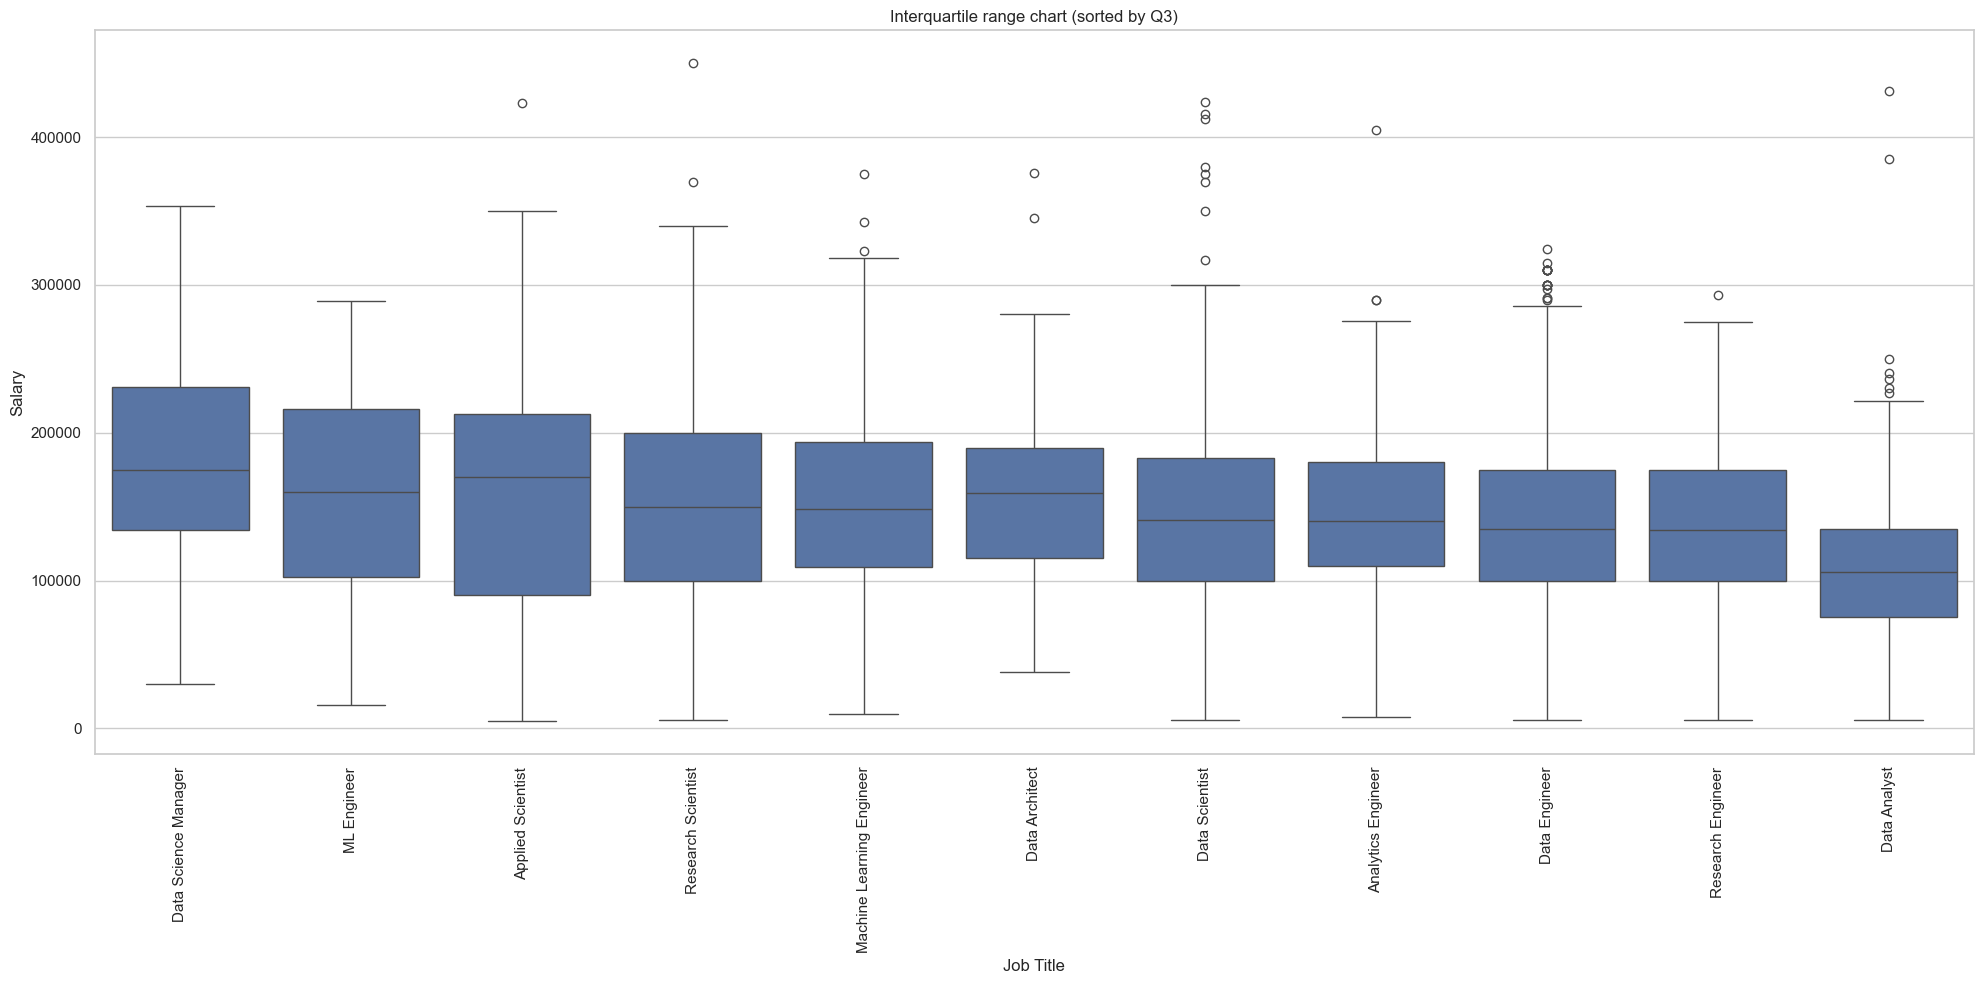

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 计算每个职位的第三四分位数并排序
q3_salaries = df.groupby('job_title')['salary_in_usd'].quantile(0.75).reset_index()
top_25_q3 = q3_salaries.sort_values(by='salary_in_usd', ascending=False)

# 创建一个Seaborn风格的图形
sns.set(style="whitegrid")

# 使用Seaborn的boxplot函数绘制四分位距图表
plt.figure(figsize=(20, 10))
sns.boxplot(x="job_title", y="salary_in_usd", data=df, order=top_25_q3['job_title'])
plt.xticks(rotation=90)  # 旋转X轴标签以避免重叠

# 添加标题和标签
plt.title("Interquartile range chart (sorted by Q3)")
plt.xlabel("Job Title")
plt.ylabel("Salary")

# 显示图表
plt.tight_layout()
plt.show()

## Step 13. Identify

In [5]:
# see the type of each column
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

## Step 14. Request

In [55]:
# calculate the percentiles

def convertData(data):

    percentiles = np.percentile(df['salary_in_usd'], [25, 50, 75])  # 25th, 50th, 75th 分位數
    print(percentiles)
    # define the labels of saraly levels 
    labels = ['Level 1', 'Level 2', 'Level 3', 'Level 4']

    # print the meaning of label 
    for i in range(len(labels)):
        if i == 0:
            print('Level 1: < {:.2f} USD'.format(percentiles[i]))
        elif i == len(labels) - 1:
            print('Level {}: > {:.2f} USD'.format(i+1, percentiles[i-1]))
        else:
            print('Level {}: {:.2f} ~ {:.2f} USD'.format(i+1, percentiles[i-1], percentiles[i]))


    #  -np.inf, np.inf be the lower and upper bounds of the bins
    # *percentiles: base on the percentiles to cut the bins and generate the salary levels for being the labels of training data
    df['salary_level'] = pd.cut(df['salary_in_usd'], bins=[-np.inf, *percentiles, np.inf], labels=labels)
    data = df.drop(['salary_in_usd'], axis=1) # we cannot put the label into the training data
    print("\nThe data of each salary level is balanced.")
    print(data['salary_level'].value_counts())
    return data

data = convertData(df)
data

[ 95000. 135000. 175000.]
Level 1: < 95000.00 USD
Level 2: 95000.00 ~ 135000.00 USD
Level 3: 135000.00 ~ 175000.00 USD
Level 4: > 175000.00 USD

The data of each salary level is balanced.
salary_level
Level 2    967
Level 1    956
Level 4    932
Level 3    900
Name: count, dtype: int64


,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_level
0,2023,Senior-level/Expert,Full-Time,Data Scientist,ES,100,ES,L,Level 1
1,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
2,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
3,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 3
4,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 2
...,...,...,...,...,...,...,...,...,...
3750,2020,Senior-level/Expert,Full-Time,Data Scientist,US,100,US,L,Level 4
3751,2021,Mid-level/Intermediate,Full-Time,Data Scientist,US,100,US,L,Level 3
3752,2020,Entry-level/Junior,Full-Time,Data Scientist,US,100,US,S,Level 2
3753,2020,Entry-level/Junior,Contract,Data Analyst,US,100,US,L,Level 2


In [7]:
# each number of salary level have approximately the same number of data which occupy 25% of the whole data

In [7]:
class SalaryDataset(Dataset):

    # 初始化函數，用於載入和預處理數據
    def __init__(self, data, train=True, transform=None):
        # train 參數用於指示是訓練數據還是測試數據
        self.train = train

        # 創建 MinMaxScaler 和 OneHotEncoder 來進行數據預處理
        minmax_scaler = MinMaxScaler()
        onehot_enc = OneHotEncoder()

        # 將數據分為類別特徵、數值特徵和標籤
        categorical_features = data[data.select_dtypes(include=['object']).columns]
        numerical_features = data[data.select_dtypes(exclude=['object']).columns].drop('salary_level', axis=1)
        label_features = data[['salary_level']]

        # 對數值特徵進行歸一化（MinMax 歸一化）
        numerical_features_arr = minmax_scaler.fit_transform(numerical_features)

        # 對類別特徵進行獨熱編碼
        categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

        # 對類別特徵進行one-hot編碼後，獲取編碼後的特徵名稱
        label_features = onehot_enc.fit_transform(label_features).toarray()

        # 將歸一化的數值特徵和獨熱編碼後的類別特徵合併成一個數據集
        combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=label_features)], axis=1).reset_index(drop=True)

        # 將數據集分為訓練集和測試集
        train_data, test_data = train_test_split(combined_features, test_size=0.2, random_state=42)

        # 根據訓練或測試模式選擇要使用的數據
        if train:
            self.data = train_data
        else:
            self.data = test_data

    # 返回數據集的長度
    def __len__(self):
        return len(self.data)

    # 用於訓練神經網絡的函數，返回特徵和標籤
    def __getitem__(self, idx):
        # 獲取在 self.data DataFrame 中的第 idx 行的數據
        sample = self.data.iloc[idx] 
        # 將一個數據結構轉換為 PyTorch 張量 並指定這個张量的數據類型為浮點數（float）
        features = torch.FloatTensor(sample[:-4])
        label = torch.FloatTensor(sample[-4:])
        return features, label

    # 返回整個數據集的 DataFrame
    def getData(self):
        return self.data


In [8]:
train_dataset = SalaryDataset(data, train=True) 
test_dataset = SalaryDataset(data, train=False)
print('train_dataset len:', len(train_dataset))
print('val_dataset len:', len(test_dataset))
print('total_dataset len:', len(train_dataset) + len(test_dataset))

train_dataset len: 3004
val_dataset len: 751
total_dataset len: 3755


In [9]:
test_dataset.getData().shape

(751, 178)

In [29]:
data.head()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior-level/Expert,Full-Time,Principal Data Scientist,ES,100,ES,L


In [11]:
dataloaders = {'train': train_dataset, 'test': test_dataset}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 3004, 'test': 751}

In [12]:


def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else: 
                    model.eval()
                
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs_vector, labels_vector in dataloaders[phase]:

                    # zero the parameter gradients 
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs_vector) # (e.g. tensor([[-1.3948, -1.4476, -1.3804, -1.3261]]))

                        # ===== !!! Here !!! ====== 
                        pred = torch.argmax(outputs).item() # (e.g. 2)
                        result = torch.argmax(labels_vector).item() # (e.g. 2) 
                        loss = criterion(outputs, labels_vector) # 
                        # ===== !!! End !!! ====== 

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item()
                    if pred == result:
                        running_corrects += 1

                if phase == 'train':
                    scheduler.step()
                # 計算每個 epoch 的 loss 和 accuracy 
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time elapsed: {round((time.time() - since))} sec.')
                
                # if found a better accuracy, save the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights 然後執行下一個 epoch 
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [13]:
# Step 3: Create a neural network model
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 4)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x


In [15]:
D_in, D_out = 174, 4
model = SalaryPredictor(D_in)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/Users/shannon/anaconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2878 Acc: 0.3708 Time elapsed: 1 sec.
test Loss: 1.1860 Acc: 0.4354 Time elapsed: 2 sec.

Epoch 1/24
----------
train Loss: 1.1486 Acc: 0.4534 Time elapsed: 3 sec.
test Loss: 1.1605 Acc: 0.4794 Time elapsed: 3 sec.

Epoch 2/24
----------
train Loss: 1.1266 Acc: 0.4664 Time elapsed: 4 sec.
test Loss: 1.1542 Acc: 0.4767 Time elapsed: 4 sec.

Epoch 3/24
----------
train Loss: 1.1164 Acc: 0.4747 Time elapsed: 6 sec.
test Loss: 1.1445 Acc: 0.4860 Time elapsed: 6 sec.

Epoch 4/24
----------
train Loss: 1.1094 Acc: 0.4790 Time elapsed: 7 sec.
test Loss: 1.1348 Acc: 0.4847 Time elapsed: 7 sec.

Epoch 5/24
----------
train Loss: 1.1044 Acc: 0.4847 Time elapsed: 8 sec.
test Loss: 1.1322 Acc: 0.4847 Time elapsed: 8 sec.

Epoch 6/24
----------
train Loss: 1.0999 Acc: 0.4850 Time elapsed: 10 sec.
test Loss: 1.1265 Acc: 0.4874 Time elapsed: 10 sec.

Epoch 7/24
----------
train Loss: 1.0802 Acc: 0.4844 Time elapsed: 11 sec.
test Loss: 1.1082 Acc: 0.4740 Time elapse

In [17]:
# save the model to disk 
torch.save(model.state_dict(), '../data/model/salary_pred.pt')

### Predict the value with the model
1. Get all data from the source.
2. Add new data to the source.
3. Convert the data to datasource for model prediction.
4. Get the model and predict the value with the last data in the source. 

> 1. Get all data from the source

In [62]:
df = pd.read_csv('../data/ds_salaries_cleaned.csv')
data = convertData(df)

[ 95000. 135000. 175000.]
Level 1: < 95000.00 USD
Level 2: 95000.00 ~ 135000.00 USD
Level 3: 135000.00 ~ 175000.00 USD
Level 4: > 175000.00 USD

The data of each salary level is balanced.
salary_level
Level 2    967
Level 1    956
Level 4    932
Level 3    900
Name: count, dtype: int64


> 2. Add new data to the source

In [78]:
hight_input = {
    'work_year': 2023,
    'experience_level': 'Senior-level/Expert',
    'employment_type': 'Full-Time',
    'job_title': 'Data Science Manager',
    'employee_residence': ['US'],
    'remote_ratio': [100],
    'company_location': ['US'],
    'company_size': ['L'],
    'salary_level': ['Level 1'] # we don't care about the label
}

low_intput = {
    'work_year': 2023,
    'experience_level': 'Entry-level/Junior',
    'employment_type': 'Full-Time',
    'job_title': 'Data Analyst',
    'employee_residence': ['US'],
    'remote_ratio': [100],
    'company_location': ['US'],
    'company_size': ['L'],
    'salary_level': ['Level 1'] # we don't care about the label
}

input = low_intput

data = pd.concat([data, pd.DataFrame(input)], ignore_index=True)
data.tail()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_level
3752,2020,Entry-level/Junior,Full-Time,Data Scientist,US,100,US,S,Level 2
3753,2020,Entry-level/Junior,Contract,Data Analyst,US,100,US,L,Level 2
3754,2021,Senior-level/Expert,Full-Time,Data Science Manager,IN,50,IN,L,Level 1
3755,2023,Senior-level/Expert,Full-Time,Data Science Manager,US,100,US,L,Level 1
3756,2023,Entry-level/Junior,Full-Time,Data Analyst,US,100,US,L,Level 1


> 3. Convert the data to datasource for model prediction.

In [66]:
data.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
salary_level          object
dtype: object

In [72]:
class DatasetConverter(Dataset):

    # 初始化函數，用於載入和預處理數據
    def __init__(self, data, transform=None):
        # 創建 MinMaxScaler 和 OneHotEncoder 來進行數據預處理
        minmax_scaler = MinMaxScaler()
        onehot_enc = OneHotEncoder()

        # 將數據分為類別特徵、數值特徵和標籤
        categorical_features = data[data.select_dtypes(include=['object']).columns].drop('salary_level', axis=1)
        categorical_columns = data.select_dtypes(include=['object']).columns
        print(f'categorical_features=${categorical_columns}')

        numerical_features = data[data.select_dtypes(exclude=['object']).columns]
        numerical_columns = data.select_dtypes(exclude=['object']).columns
        print(f'numerical_features=${numerical_columns}')
        
        label_features = data[['salary_level']]

        # 對數值特徵進行歸一化（MinMax 歸一化）
        numerical_features_arr = minmax_scaler.fit_transform(numerical_features)

        # 對類別特徵進行獨熱編碼
        categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

        # 對類別特徵進行one-hot編碼後，獲取編碼後的特徵名稱
        label_features = onehot_enc.fit_transform(label_features).toarray()

        # 將歸一化的數值特徵和獨熱編碼後的類別特徵合併成一個數據集
        combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=label_features)], axis=1).reset_index(drop=True)

        self.data = combined_features

    # 返回數據集的長度
    def __len__(self):
        return len(self.data)

    # 用於訓練神經網絡的函數，返回特徵和標籤
    def __getitem__(self, idx):
        # 獲取在 self.data DataFrame 中的第 idx 行的數據
        sample = self.data.iloc[idx] 
        # 將一個數據結構轉換為 PyTorch 張量 並指定這個张量的數據類型為浮點數（float）
        features = torch.FloatTensor(sample[:-4])
        label = torch.FloatTensor(sample[-4:])
        return features, label

    # 返回整個數據集的 DataFrame
    def getData(self):
        return self.data


In [79]:
tensor_input = DatasetConverter(data).__getitem__(-1)[0]
tensor_label = DatasetConverter(data).__getitem__(-1)[1]
print(f'tensor_input = ${tensor_input}, \ntensor_label = ${tensor_label}')

categorical_features=$Index(['experience_level', 'employment_type', 'job_title',
       'employee_residence', 'company_location', 'company_size',
       'salary_level'],
      dtype='object')
numerical_features=$Index(['work_year', 'remote_ratio'], dtype='object')
categorical_features=$Index(['experience_level', 'employment_type', 'job_title',
       'employee_residence', 'company_location', 'company_size',
       'salary_level'],
      dtype='object')
numerical_features=$Index(['work_year', 'remote_ratio'], dtype='object')
tensor_input = $tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

In [80]:
# load the model from disk
D_in, D_out = 174, 4
pred_model = SalaryPredictor(D_in)
pred_model.load_state_dict(torch.load('../data/model/salary_pred.pt'))

# predict the salary level of the new data
with torch.no_grad():
    # get the last row of the data
    tensor_data = DatasetConverter(data).__getitem__(-1)
    input = tensor_data[0]
    output = pred_model(input)
    print(f'output = ${output}')
    pred = torch.argmax(output).item()
    print('The predicted salary level is:', pred)

categorical_features=$Index(['experience_level', 'employment_type', 'job_title',
       'employee_residence', 'company_location', 'company_size',
       'salary_level'],
      dtype='object')
numerical_features=$Index(['work_year', 'remote_ratio'], dtype='object')
output = $tensor([ 2.1401,  0.8742, -0.7761, -1.9148])
The predicted salary level is: 0
